# Comparing Gene Expression in Young vs Aged Hematopoietic Stem Cells

This is an analysis of bulk RNAseq data comparing expression in the hematopoietic stem cells of 10-week-old (young) vs 20-month-old (aged) mice.

In [1]:
# Suppress warnings
options(warn = -1)

# load packages
library(tximport)
library(ensembldb)
library(AnnotationHub)
library(DESeq2)

library(ggplot2)
library(dplyr)
library(pheatmap)
library(RColorBrewer)

library(biomaRt)

library(EnhancedVolcano)

# increase size of plots from default
options(repr.plot.width = 14, 
        repr.plot.height = 14) # from 7, 7

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomeInfoDb

Loa

## Create annotation dataframes for `tximport`

In [2]:
# create an AnnotationHub object
ah = AnnotationHub()

# find relevant annotation records
ahs2 <- query(ah, c("110","Ensembl", "Mus musculus"))

# load latest annotation record for Mus musculus
ensdb_110 <- ahs2[["AH113713"]]

# Extract transcript and gene information
tx_data <- transcripts(ensdb_110, return.type = "DataFrame")

# Create the tx2gene data.frame
tx2gene <- tx_data[, c("tx_id", "gene_id")]
tx2gene

loading from cache



DataFrame with 149547 rows and 2 columns
                    tx_id            gene_id
              <character>        <character>
1      ENSMUST00000082387 ENSMUSG00000064336
2      ENSMUST00000179436 ENSMUSG00000095742
3      ENSMUST00000082388 ENSMUSG00000064337
4      ENSMUST00000082389 ENSMUSG00000064338
5      ENSMUST00000082390 ENSMUSG00000064339
...                   ...                ...
149543 ENSMUST00000192752 ENSMUSG00000102236
149544 ENSMUST00020183637 ENSMUSG00002076810
149545 ENSMUST00020183310 ENSMUSG00002075165
149546 ENSMUST00000192733 ENSMUSG00000104297
149547 ENSMUST00000194529 ENSMUSG00000102307

## Load `salmon` quantification files 

In [3]:
# prep salmon quant files for the 4 samples for tximport
quants_dir <- "results/03_salmon_quant/"
all_files <- list.files(quants_dir, pattern = "quant.sf$", recursive = TRUE, full.names = TRUE)
quant_files <- all_files[grepl("SRR.*quant.sf", all_files)] # Use grepl to select only quant.sf files
quant_dirs <- list.files(quants_dir, pattern = "quant_SRR.*", full.names = TRUE)
sample_names <- sub('.*SRR([0-9]+).*', 'SRR\\1', quant_dirs)  # get sample names from dir names
names(quant_files) <- sample_names
as.data.frame(quant_files)

,quant_files
,<chr>
SRR13192285,results/03_salmon_quant//quant_SRR13192285/quant.sf
SRR13192286,results/03_salmon_quant//quant_SRR13192286/quant.sf
SRR13192301,results/03_salmon_quant//quant_SRR13192301/quant.sf
SRR13192302,results/03_salmon_quant//quant_SRR13192302/quant.sf


In [4]:
# tximport quant_files
txi <- tximport(quant_files, 
                type = "salmon", 
                tx2gene = tx2gene, 
                ignoreTxVersion = TRUE)
str(txi)

reading in files with read_tsv

1 
2 
3 
4 


transcripts missing from tx2gene: 216

summarizing abundance

summarizing counts

summarizing length

summarizing inferential replicates



List of 5
 $ abundance          : num [1:55800, 1:4] 95.09 0 13.99 1.04 2.72 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:55800] "ENSMUSG00000000001" "ENSMUSG00000000003" "ENSMUSG00000000028" "ENSMUSG00000000031" ...
  .. ..$ : chr [1:4] "SRR13192285" "SRR13192286" "SRR13192301" "SRR13192302"
 $ counts             : num [1:55800, 1:4] 3921 0 336 18.7 120 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:55800] "ENSMUSG00000000001" "ENSMUSG00000000003" "ENSMUSG00000000028" "ENSMUSG00000000031" ...
  .. ..$ : chr [1:4] "SRR13192285" "SRR13192286" "SRR13192301" "SRR13192302"
 $ infReps            :List of 4
  ..$ SRR13192285: num [1:55800, 1:20] 3901 0 316 30 111 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:55800] "ENSMUSG00000000001" "ENSMUSG00000000003" "ENSMUSG00000000028" "ENSMUSG00000000031" ...
  .. .. ..$ : NULL
  ..$ SRR13192286: num [1:55800, 1:20] 5340.4 0 348 30.4 125.1 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:55800

## Create `DESeqDataSet`

In [5]:
# create sample table
condition <- factor(c('young', 'young', 'aged', 'aged'))
coldata <- data.frame(row.names = sample_names, condition)
coldata

,condition
,<fct>
SRR13192285,young
SRR13192286,young
SRR13192301,aged
SRR13192302,aged


In [6]:
# create deseq object
dds <- DESeqDataSetFromTximport(txi, coldata, ~ condition)
dds

using counts and average transcript lengths from tximport



class: DESeqDataSet 
dim: 55800 4 
metadata(1): version
assays(2): counts avgTxLength
rownames(55800): ENSMUSG00000000001 ENSMUSG00000000003 ...
  ENSMUSG00002076991 ENSMUSG00002076992
rowData names(0):
colnames(4): SRR13192285 SRR13192286 SRR13192301 SRR13192302
colData names(1): condition

In [7]:
# drop genes with fewer than 12 counts total across all samples
keep <- rowSums(counts(dds)) > 12
dds <- dds[keep, ]
dds

class: DESeqDataSet 
dim: 17174 4 
metadata(1): version
assays(2): counts avgTxLength
rownames(17174): ENSMUSG00000000001 ENSMUSG00000000028 ...
  ENSMUSG00002076814 ENSMUSG00002076847
rowData names(0):
colnames(4): SRR13192285 SRR13192286 SRR13192301 SRR13192302
colData names(1): condition

## Visualization

using 'avgTxLength' from assays(dds), correcting for library size



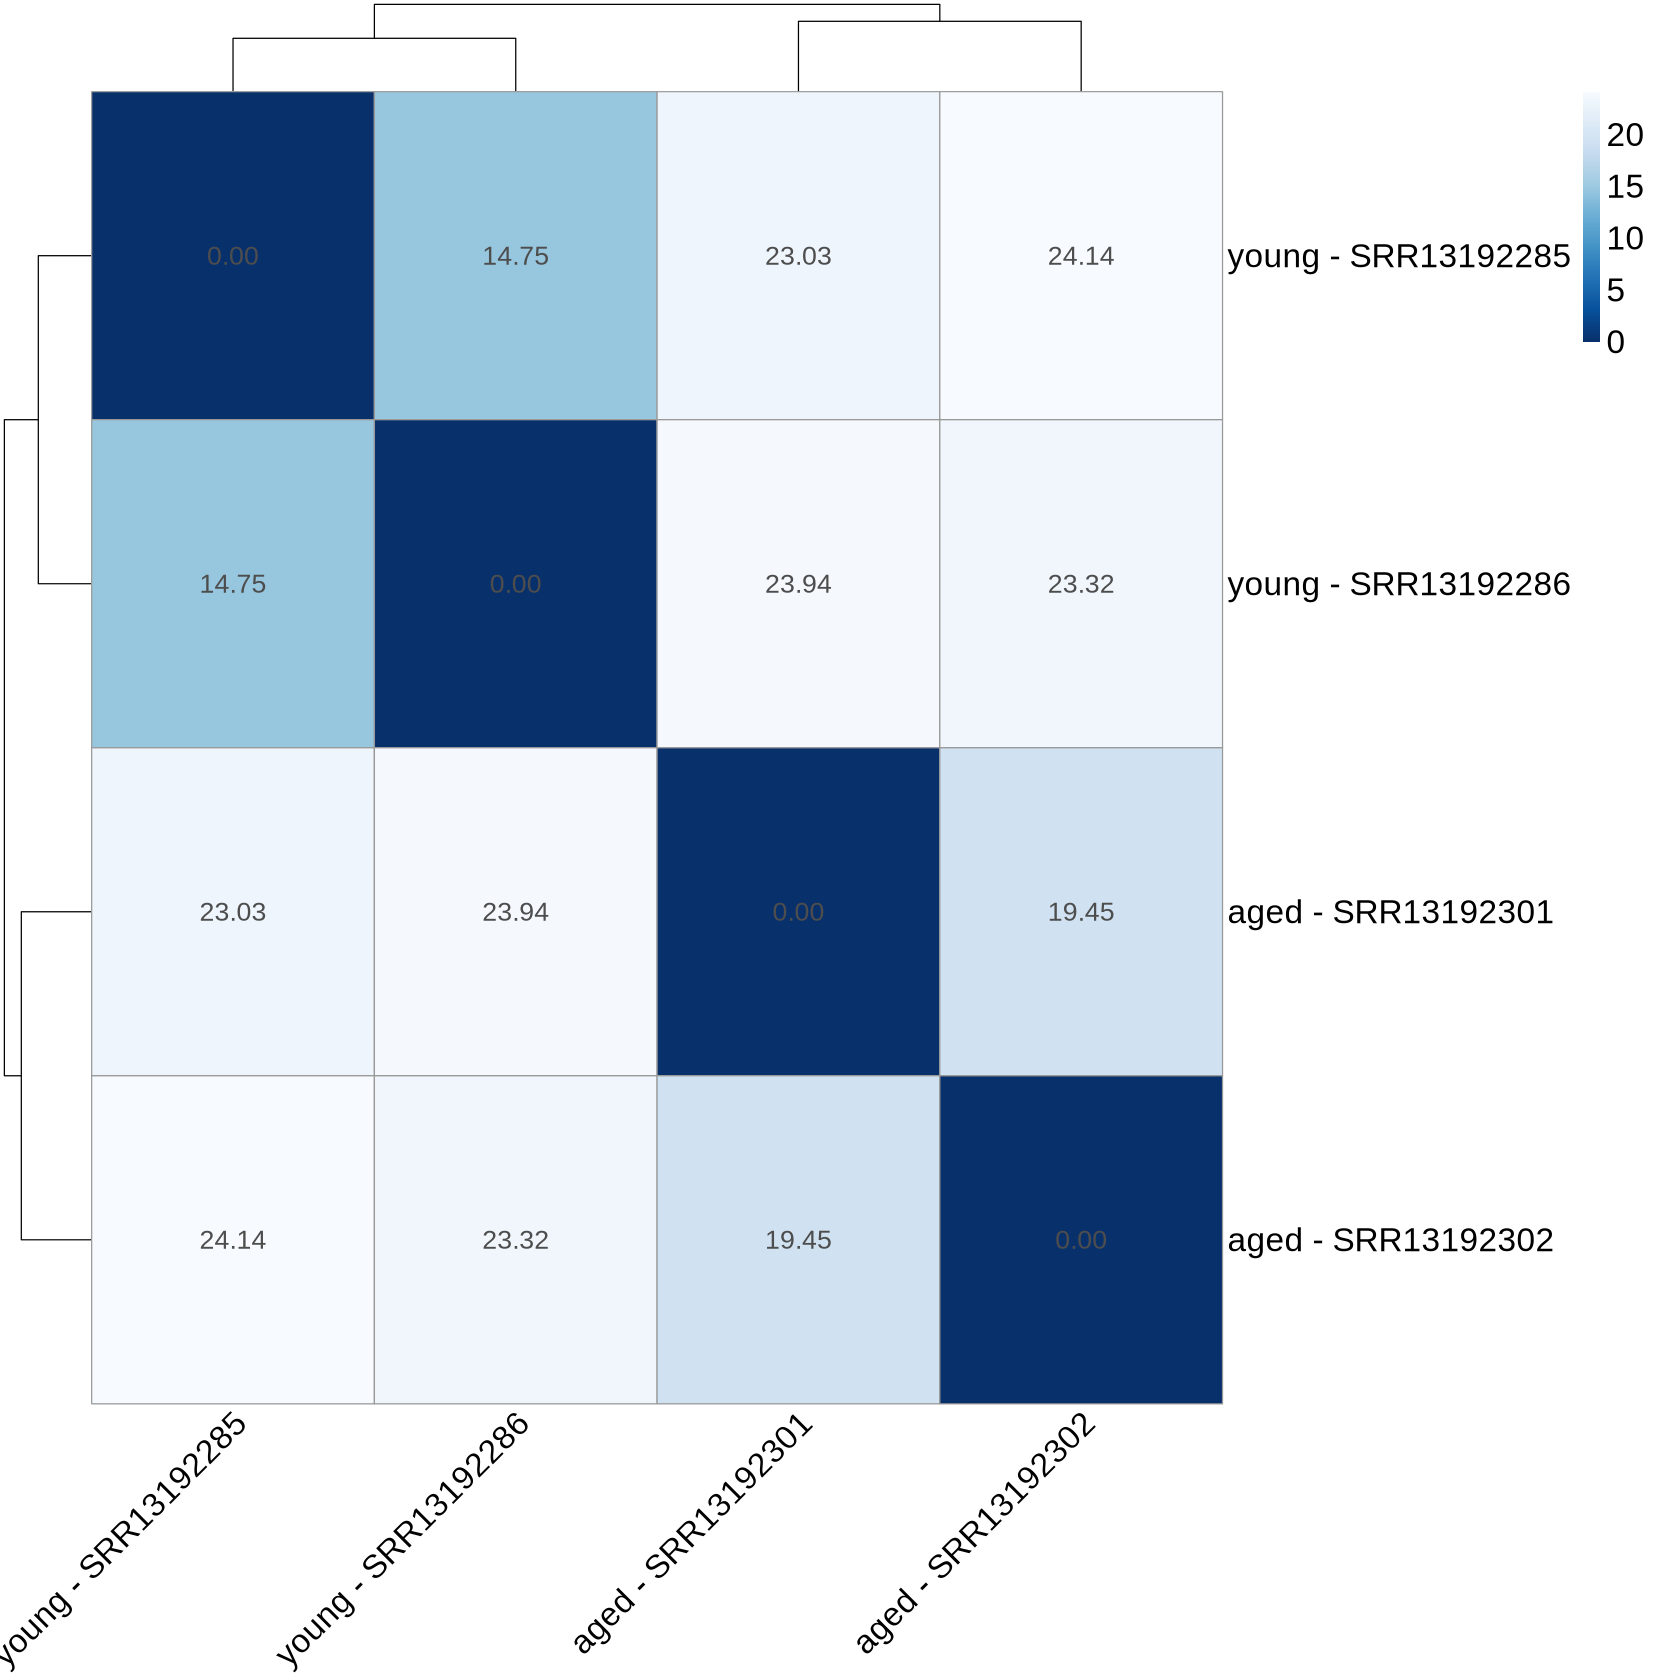

In [8]:
# rlog transformation to stabilize variance
rld <- rlog(dds)

# sample distances
sampleDists <- dist(t(assay(rld)))

# heatmap
sampleDistMatrix <- as.matrix( sampleDists )
rownames(sampleDistMatrix) <- paste( rld$condition, colnames(rld), sep = " - " )
colnames(sampleDistMatrix) <- rownames(sampleDistMatrix)#NULL
colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)
pheatmap(sampleDistMatrix,
         clustering_distance_rows = sampleDists,
         clustering_distance_cols = sampleDists,
         col = colors, 
        angle_col = 45, fontsize = 20, 
        display_numbers = TRUE)

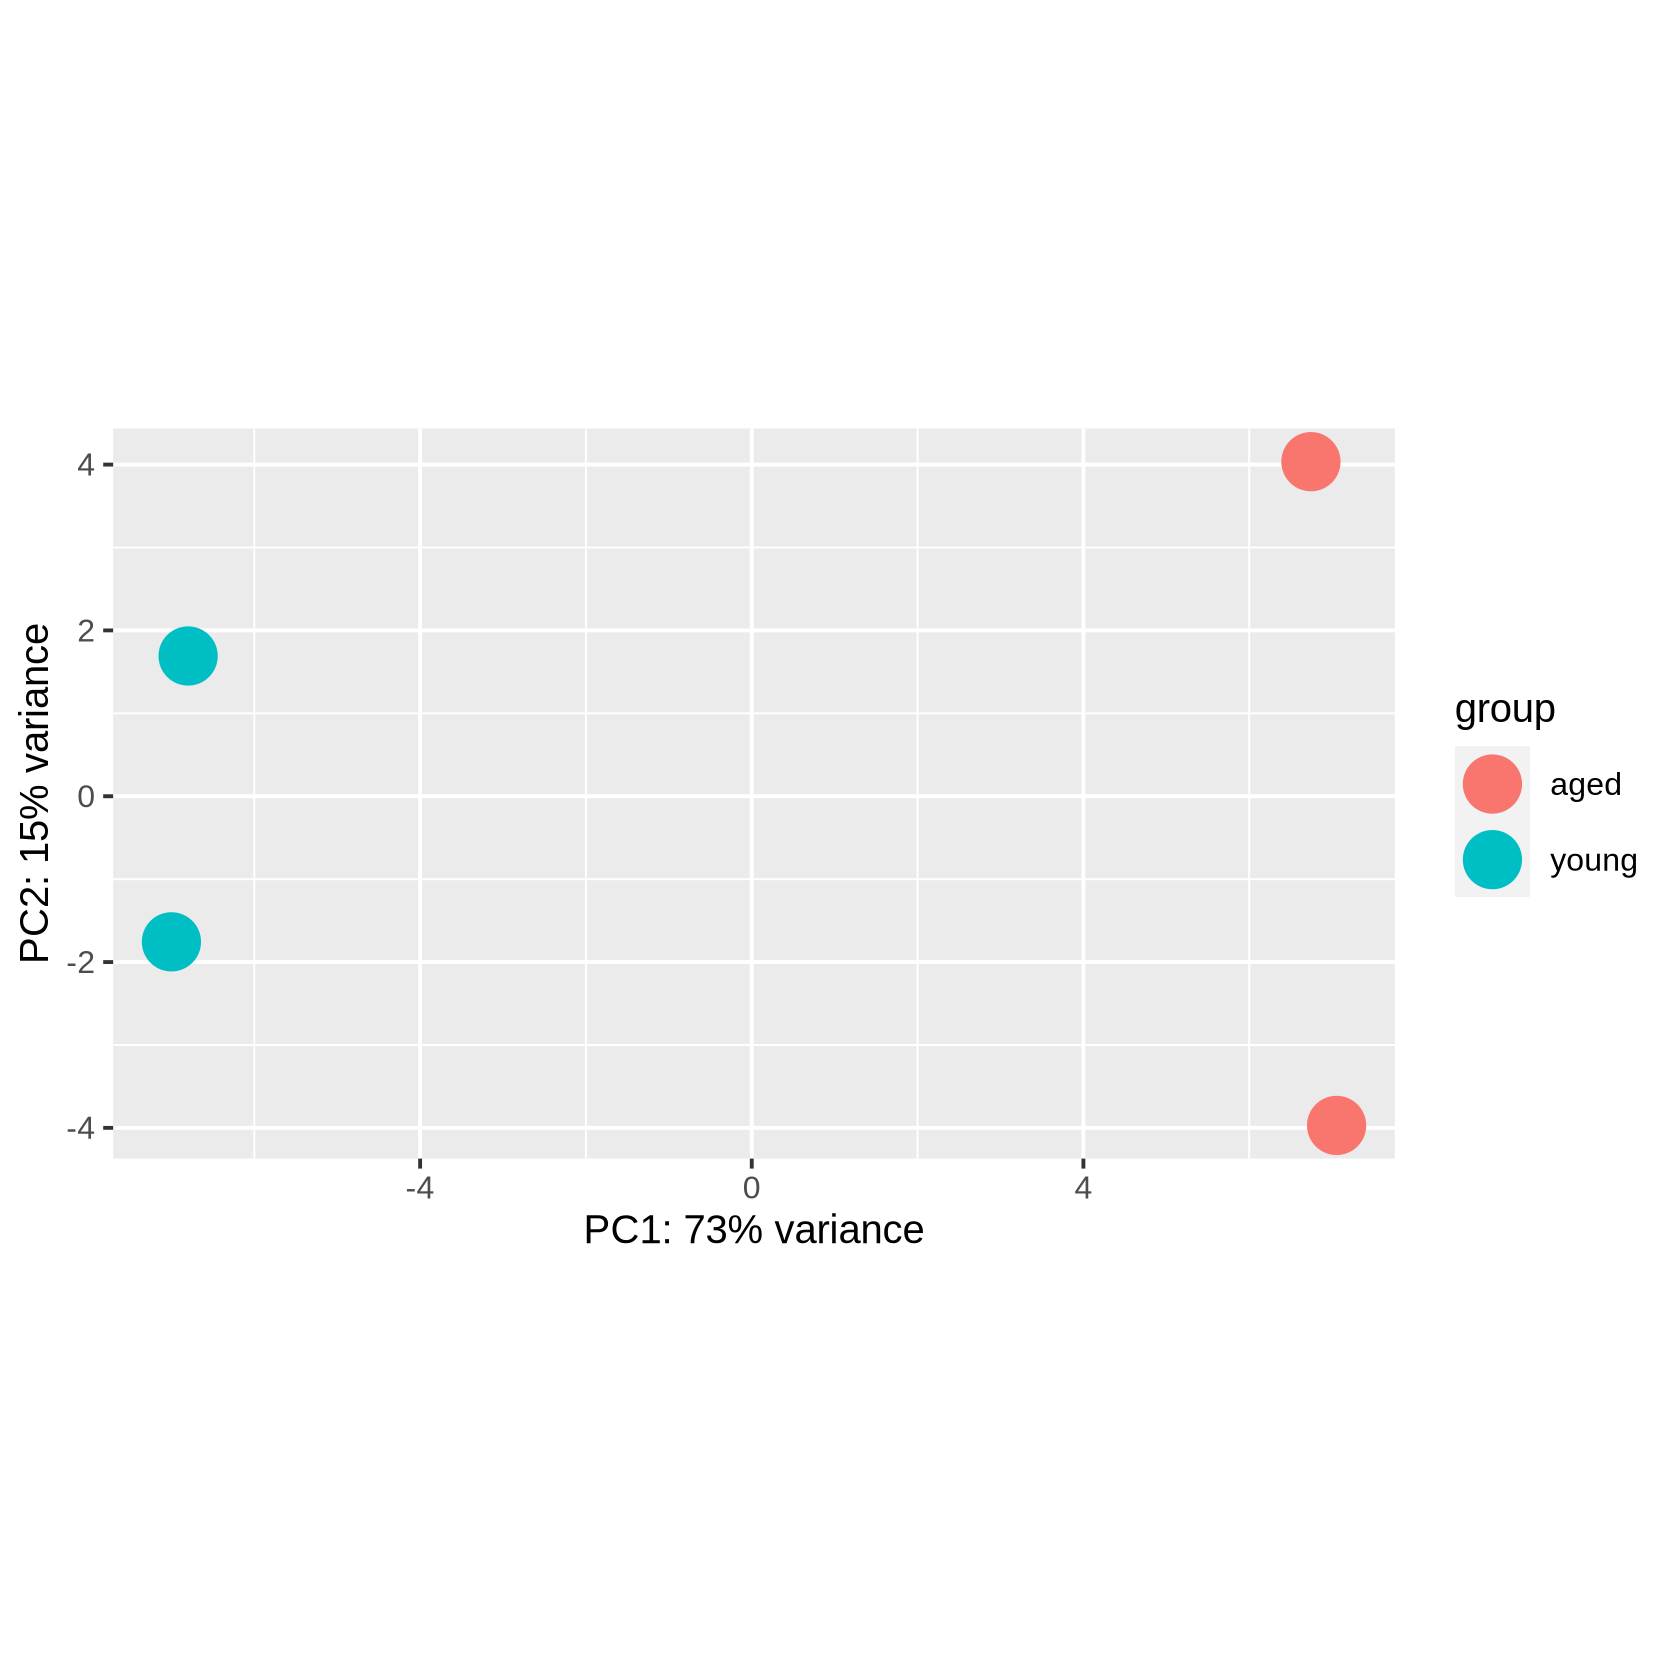

In [9]:
# PCA
object <- rld
ntop <- 500 # number of variable genes to use for PCA
intgroup <- 'condition'
pcsToUse = 1:2

rv <- rowVars(assay(object))
select <- order(rv, decreasing = TRUE)[seq_len(min(ntop, length(rv)))]
pca <- prcomp(t(assay(object)[select, ]))
percentVar <- pca$sdev^2/sum(pca$sdev^2)

intgroup.df <- as.data.frame(colData(object)[, intgroup, drop = FALSE])
group <- colData(object)[[intgroup]]

pcs <- paste0("PC", pcsToUse)
d <- data.frame(V1 = pca$x[, pcsToUse[1]], V2 = pca$x[, pcsToUse[2]], 
                group = group, intgroup.df, name = colnames(object))
colnames(d)[1:2] <- pcs

ggplot(data = d, aes(x = PC1, y = PC2, color = group)) + 
    geom_point(size = 16) + 
    xlab(paste0(pcs[1], ": ", round(percentVar[pcsToUse[1]] * 100), "% variance")) + 
    ylab(paste0(pcs[2], ": ", round(percentVar[pcsToUse[2]] * 100), "% variance")) + 
    coord_fixed() + 
    theme_gray(base_size = 24)

## Differential expression analysis

In [10]:
dds <- DESeq(dds)
dds

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



class: DESeqDataSet 
dim: 17174 4 
metadata(1): version
assays(6): counts avgTxLength ... H cooks
rownames(17174): ENSMUSG00000000001 ENSMUSG00000000028 ...
  ENSMUSG00002076814 ENSMUSG00002076847
rowData names(22): baseMean baseVar ... deviance maxCooks
colnames(4): SRR13192285 SRR13192286 SRR13192301 SRR13192302
colData names(1): condition

In [11]:
res <- results(dds)
summary(res)
res


out of 17174 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 352, 2%
LFC < 0 (down)     : 573, 3.3%
outliers [1]       : 0, 0%
low counts [2]     : 1665, 9.7%
(mean count < 6)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



log2 fold change (MLE): condition young vs aged 
Wald test p-value: condition young vs aged 
DataFrame with 17174 rows and 6 columns
                     baseMean log2FoldChange     lfcSE      stat    pvalue
                    <numeric>      <numeric> <numeric> <numeric> <numeric>
ENSMUSG00000000001 4448.00617       0.116540  0.180609  0.645261 0.5187580
ENSMUSG00000000028  401.92741      -0.305754  0.243951 -1.253341 0.2100818
ENSMUSG00000000031    8.85933       2.886619  1.554810  1.856573 0.0633719
ENSMUSG00000000037  103.69991       0.784844  0.425637  1.843929 0.0651935
ENSMUSG00000000056  503.75208       0.350392  0.299206  1.171071 0.2415703
...                       ...            ...       ...       ...       ...
ENSMUSG00002076664   79.79029      -0.108099  0.471625 -0.229206 0.8187087
ENSMUSG00002076697   51.80738       1.208351  0.597565  2.022124 0.0431636
ENSMUSG00002076809   10.25885      -1.451036  1.590038 -0.912580 0.3614636
ENSMUSG00002076814    3.51613       0.6603

In [12]:
# using more stringent thresholds: BH FDR adjusted p-value 0.01 vs 0.1, LFC 0.1 vs 0
res <- results(dds, alpha = 0.01, lfcThreshold=0.1)
summary(res)
res


out of 17174 with nonzero total read count
adjusted p-value < 0.01
LFC > 0.10 (up)    : 83, 0.48%
LFC < -0.10 (down) : 242, 1.4%
outliers [1]       : 0, 0%
low counts [2]     : 2331, 14%
(mean count < 9)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



log2 fold change (MLE): condition young vs aged 
Wald test p-value: condition young vs aged 
DataFrame with 17174 rows and 6 columns
                     baseMean log2FoldChange     lfcSE       stat    pvalue
                    <numeric>      <numeric> <numeric>  <numeric> <numeric>
ENSMUSG00000000001 4448.00617       0.116540  0.180609  0.0915794 0.9270322
ENSMUSG00000000028  401.92741      -0.305754  0.243951 -0.8434226 0.3989922
ENSMUSG00000000031    8.85933       2.886619  1.554810  1.7922569 0.0730918
ENSMUSG00000000037  103.69991       0.784844  0.425637  1.6089868 0.1076192
ENSMUSG00000000056  503.75208       0.350392  0.299206  0.8368534 0.4026749
...                       ...            ...       ...        ...       ...
ENSMUSG00002076664   79.79029      -0.108099  0.471625 -0.0171732 0.9862985
ENSMUSG00002076697   51.80738       1.208351  0.597565  1.8547779 0.0636279
ENSMUSG00002076809   10.25885      -1.451036  1.590038 -0.8496883 0.3954984
ENSMUSG00002076814    3.51613  

In [13]:
# add BIOMART gene symbols to res based on Ensembl IDs in rownames
ensembl <- useMart("ensembl", dataset = 'mmusculus_gene_ensembl')
res$symbol <- getBM(attributes = c('ensembl_gene_id','external_gene_name'),
                          filters = "ensembl_gene_id",
                          values = rownames(res),
                          mart = ensembl)$external_gene_name
res

log2 fold change (MLE): condition young vs aged 
Wald test p-value: condition young vs aged 
DataFrame with 17174 rows and 7 columns
                     baseMean log2FoldChange     lfcSE       stat    pvalue
                    <numeric>      <numeric> <numeric>  <numeric> <numeric>
ENSMUSG00000000001 4448.00617       0.116540  0.180609  0.0915794 0.9270322
ENSMUSG00000000028  401.92741      -0.305754  0.243951 -0.8434226 0.3989922
ENSMUSG00000000031    8.85933       2.886619  1.554810  1.7922569 0.0730918
ENSMUSG00000000037  103.69991       0.784844  0.425637  1.6089868 0.1076192
ENSMUSG00000000056  503.75208       0.350392  0.299206  0.8368534 0.4026749
...                       ...            ...       ...        ...       ...
ENSMUSG00002076664   79.79029      -0.108099  0.471625 -0.0171732 0.9862985
ENSMUSG00002076697   51.80738       1.208351  0.597565  1.8547779 0.0636279
ENSMUSG00002076809   10.25885      -1.451036  1.590038 -0.8496883 0.3954984
ENSMUSG00002076814    3.51613  

In [14]:
# what genes have the strongest down-regulation in young?
resSig <- subset(res, padj < 0.01)
head(resSig[ order(resSig$log2FoldChange), ])

log2 fold change (MLE): condition young vs aged 
Wald test p-value: condition young vs aged 
DataFrame with 6 rows and 7 columns
                    baseMean log2FoldChange     lfcSE      stat      pvalue
                   <numeric>      <numeric> <numeric> <numeric>   <numeric>
ENSMUSG00000069008   91.8324      -23.36077   4.78533  -4.86085 1.16883e-06
ENSMUSG00000078377   96.7285      -10.01129   1.53151  -6.47157 9.69873e-11
ENSMUSG00002076515   86.8913       -9.85767   1.51695  -6.43244 1.25573e-10
ENSMUSG00000056399   73.3835       -9.61666   1.55967  -6.10170 1.04949e-09
ENSMUSG00000096780   56.0776       -9.22806   1.56153  -5.84558 5.04803e-09
ENSMUSG00000020907   24.9830       -8.06077   1.67425  -4.75483 1.98617e-06
                          padj      symbol
                     <numeric> <character>
ENSMUSG00000069008 1.02053e-04      Gm5537
ENSMUSG00000078377 1.73444e-08      Gm4294
ENSMUSG00002076515 2.19280e-08     Gm55628
ENSMUSG00000056399 1.56376e-07      Prss34
ENSMU

In [15]:
# what genes have the strongest UP-regulation in young?
head(resSig[ order(resSig$log2FoldChange, decreasing = TRUE), ])

log2 fold change (MLE): condition young vs aged 
Wald test p-value: condition young vs aged 
DataFrame with 6 rows and 7 columns
                    baseMean log2FoldChange     lfcSE      stat      pvalue
                   <numeric>      <numeric> <numeric> <numeric>   <numeric>
ENSMUSG00000095545   85.1770       22.60390   4.78539   4.70263 2.56837e-06
ENSMUSG00000118588  190.4591       11.04104   1.47942   7.39549 1.40885e-13
ENSMUSG00000040715   24.3184        8.06887   1.70652   4.66967 3.01685e-06
ENSMUSG00000096718   19.8433        7.78027   1.73242   4.43326 9.28207e-06
ENSMUSG00000081309   15.3672        7.40883   1.80461   4.05009 5.11982e-05
ENSMUSG00000036040   15.5610        6.03517   1.52324   3.89642 9.76251e-05
                          padj      symbol
                     <numeric> <character>
ENSMUSG00000095545 2.03863e-04      Zfp969
ENSMUSG00000118588 3.80210e-11     Gm56487
ENSMUSG00000040715 2.36067e-04      Rsc1a1
ENSMUSG00000096718 6.78688e-04      Zfp781
ENSMU

## plotting differential expression results

### Volcano plot

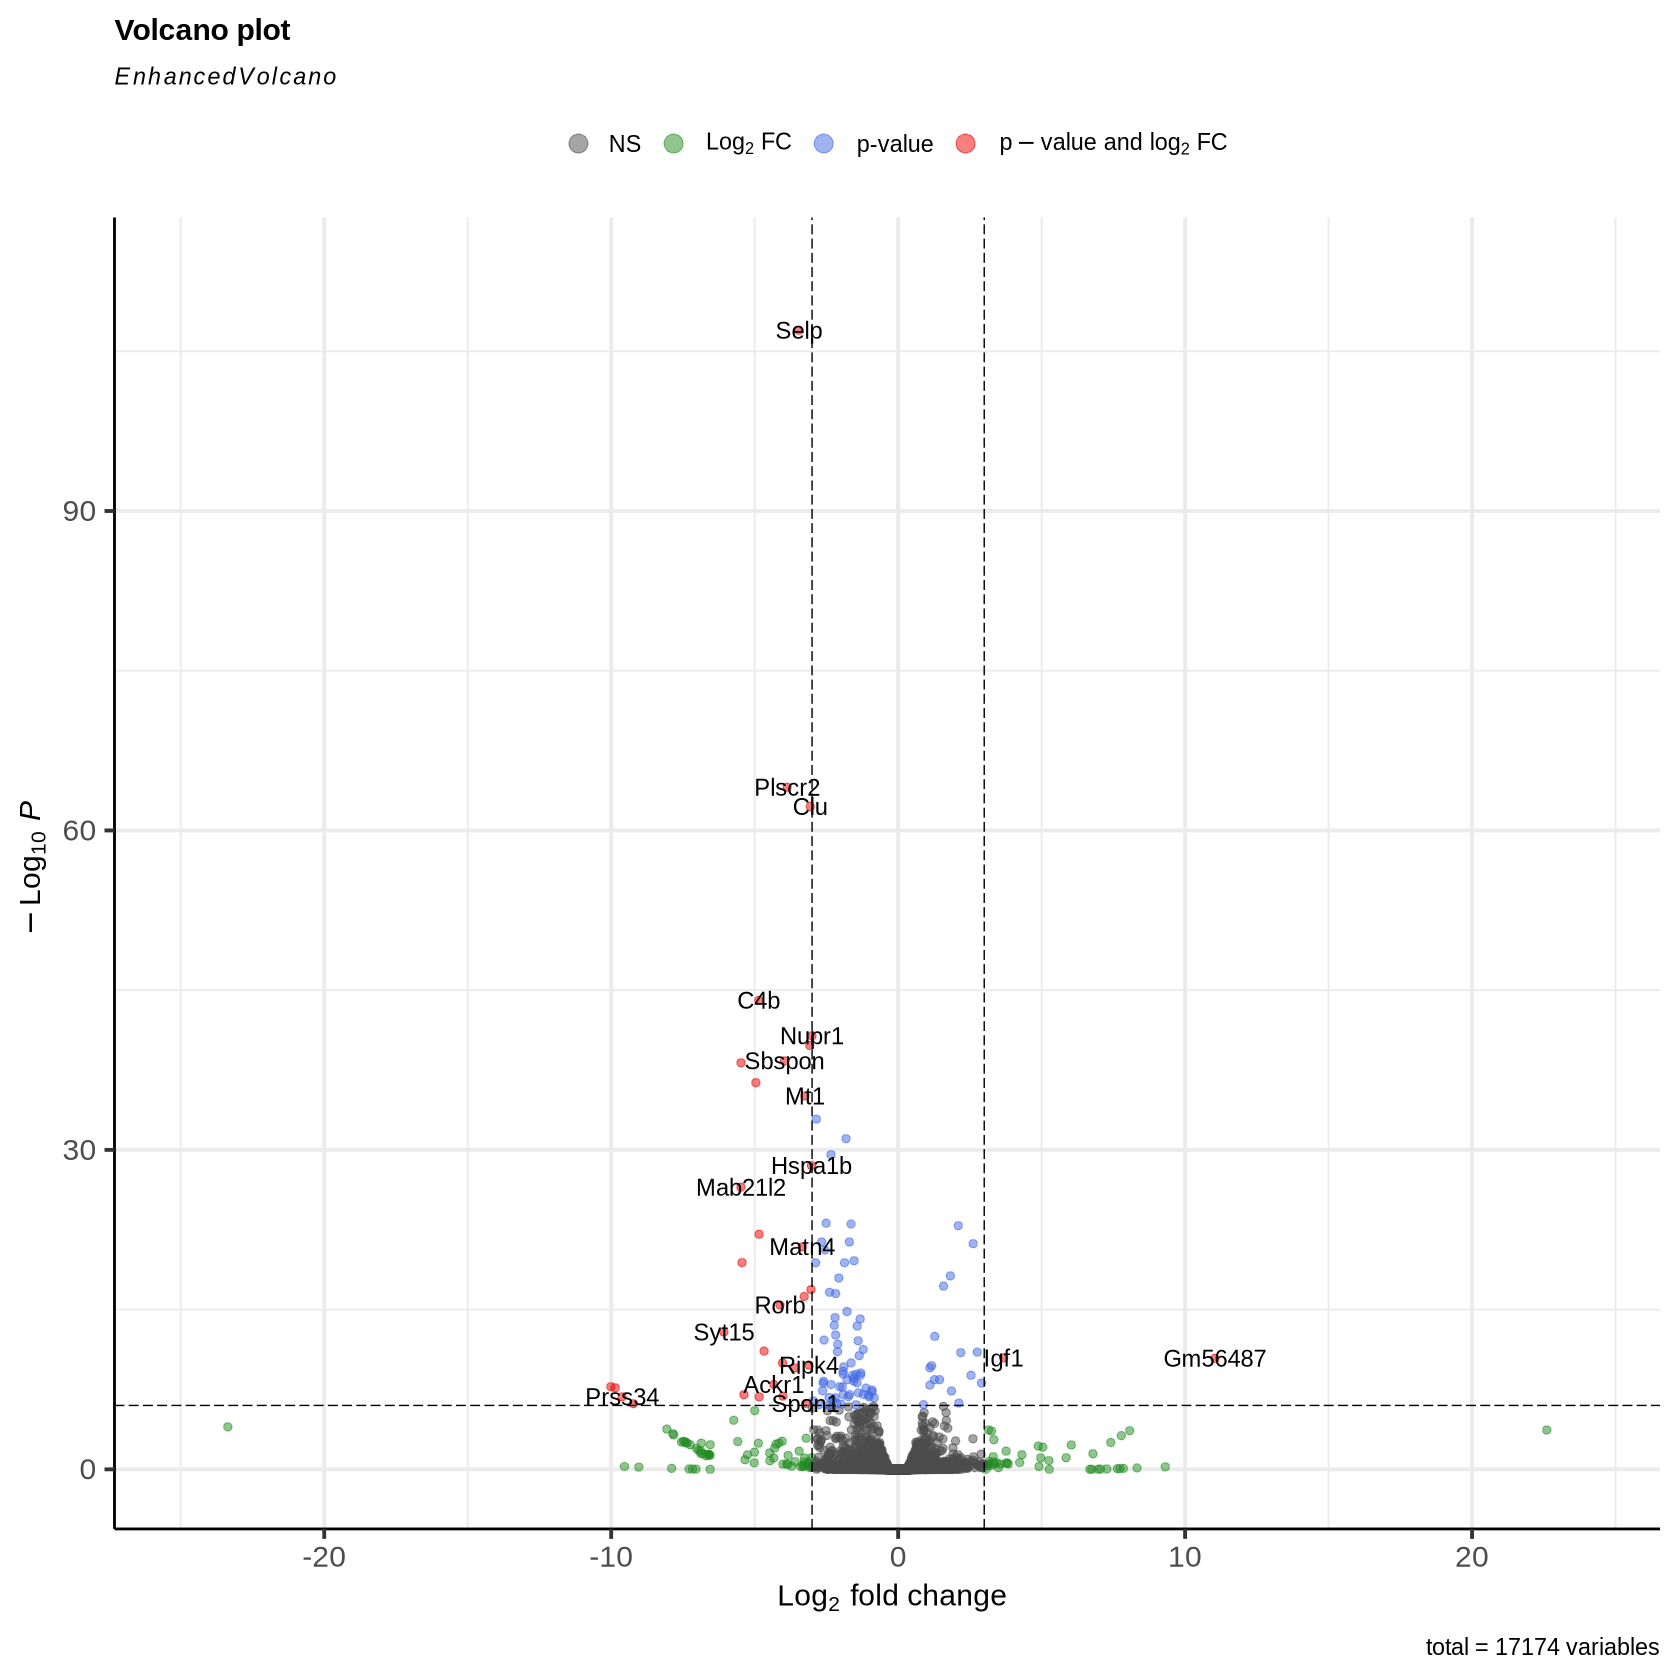

In [20]:
EnhancedVolcano(as.data.frame(res), x = 'log2FoldChange', y = 'padj', lab = as.data.frame(res)$'symbol', 
               pCutoff = 1e-06, FCcutoff = 3, 
               xlim = c(-12, 12))

### Heatmap

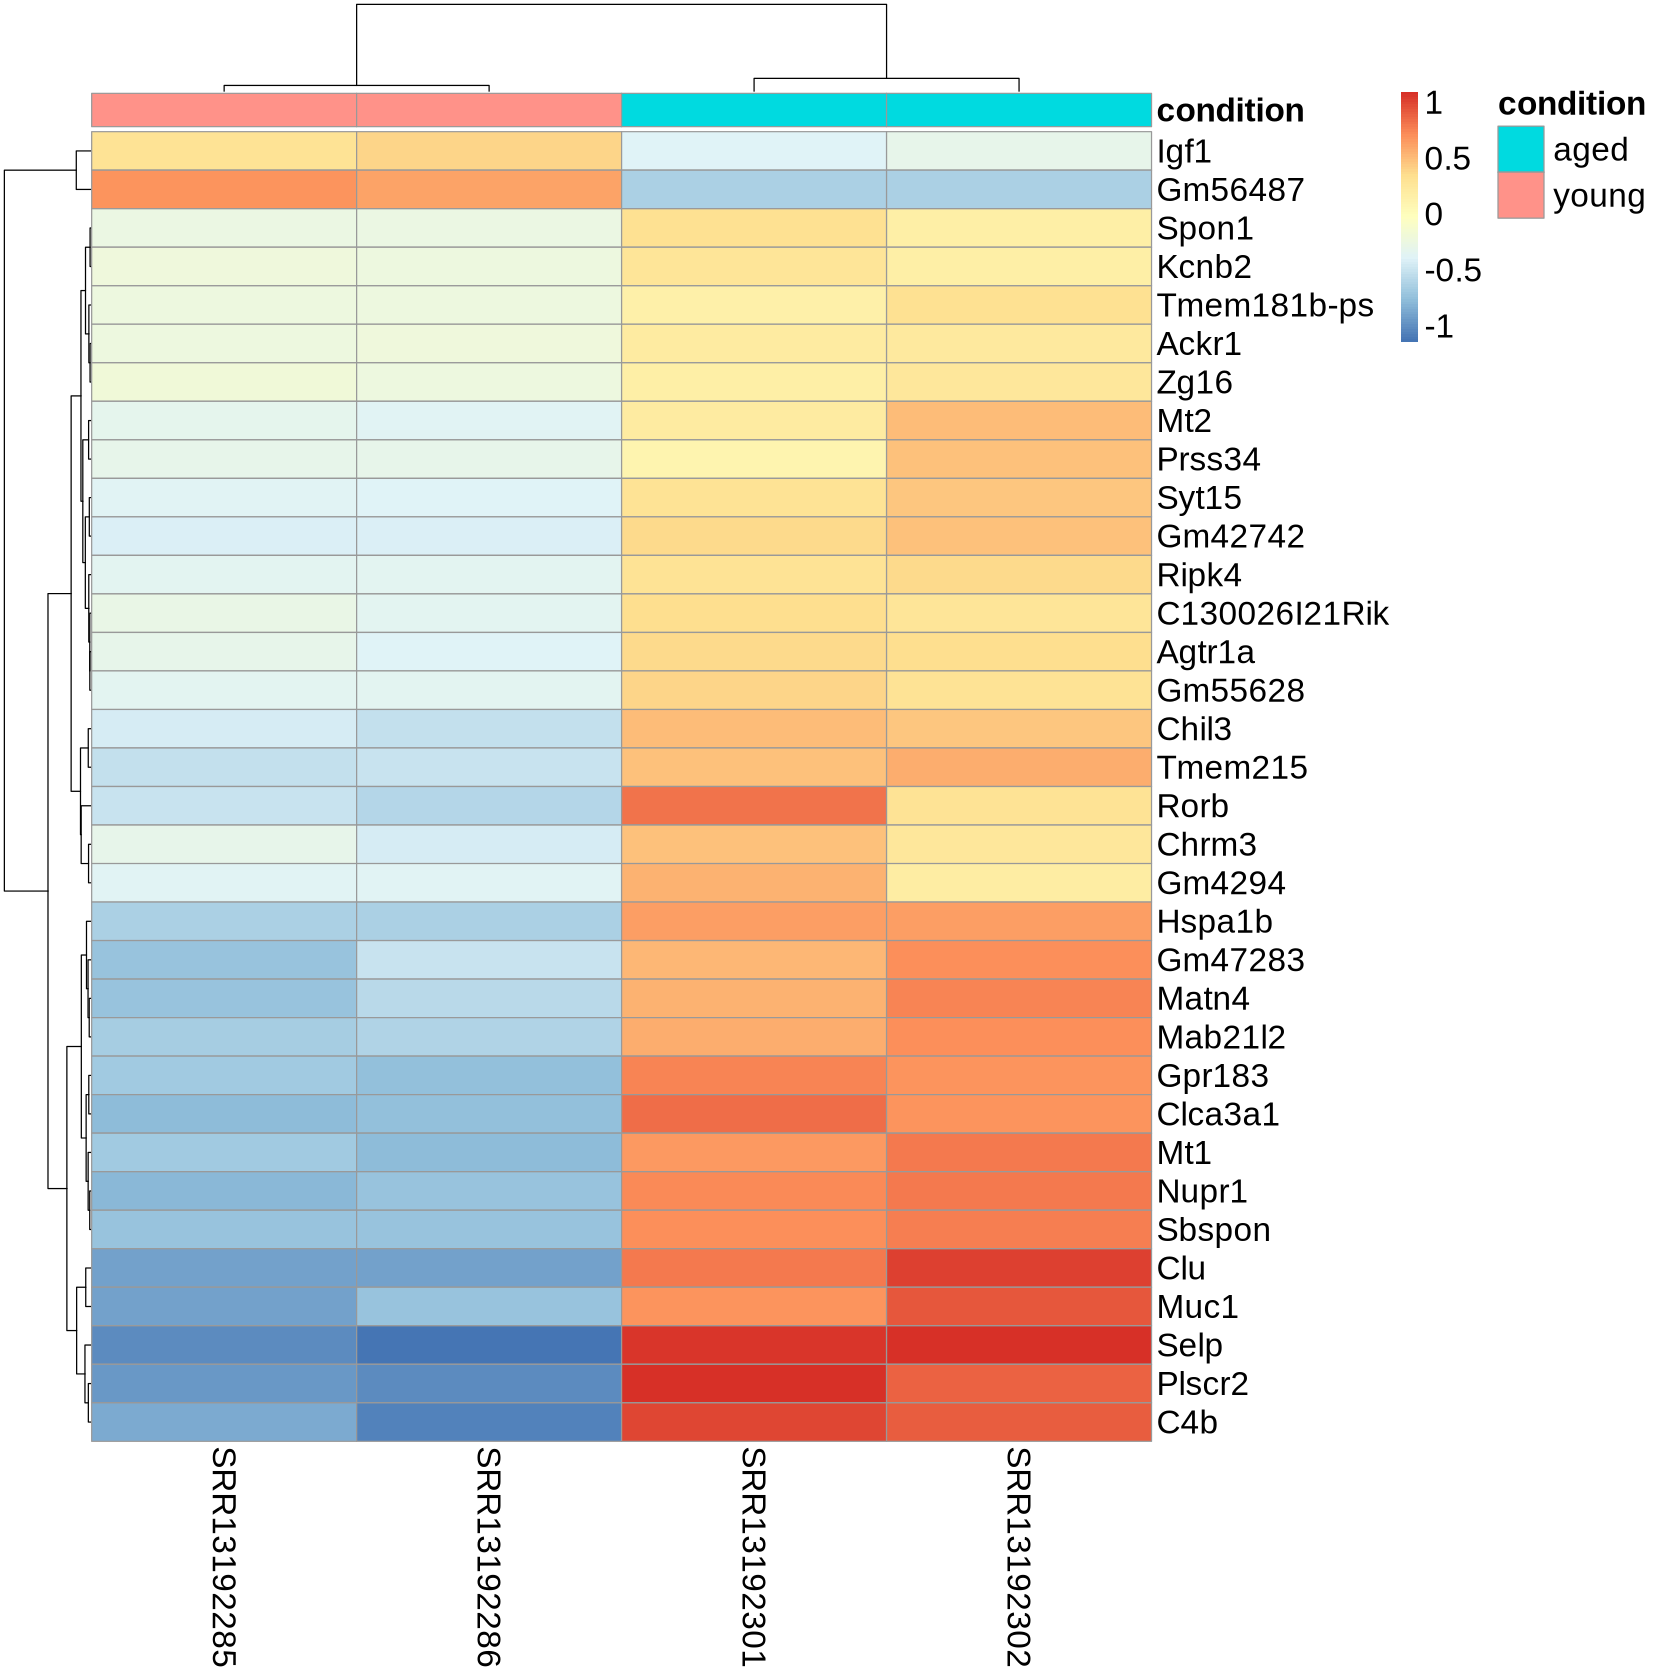

In [22]:
# heatmap of genes with strongest signal
resSig <- subset(res, padj < 1e-6 & abs(log2FoldChange) > 3)
# Create a named vector for mapping Ensembl IDs to gene symbols
ensembl_to_symbol <- setNames(res$symbol, rownames(res))
# select only resSig genes instead of heatmap of all ~17,000 genes
mat  <- assay(rld)[rownames(resSig), ] 
# heatmap of deviation from mean expression instead of actual expression
mat  <- mat - rowMeans(mat) 
# annotate heatmap columns with sample name
anno <- as.data.frame(colData(rld))
pheatmap(mat, 
         annotation_col = anno, 
        labels_row = ensembl_to_symbol[rownames(mat)], 
        fontsize = 20)

In [27]:
resSig[ order(resSig$padj, decreasing = FALSE), c('baseMean', 'log2FoldChange', 'padj', 'symbol')]

log2 fold change (MLE): condition young vs aged 
 
DataFrame with 34 rows and 4 columns
                    baseMean log2FoldChange         padj      symbol
                   <numeric>      <numeric>    <numeric> <character>
ENSMUSG00000026580  4174.971       -3.45237 1.07575e-107        Selp
ENSMUSG00000032372   956.505       -3.86791  8.69141e-65      Plscr2
ENSMUSG00000022037  2046.566       -3.06303  5.65562e-63         Clu
ENSMUSG00000073418   530.118       -4.85742  9.03681e-45         C4b
ENSMUSG00000030717   764.574       -3.00453  1.91975e-41       Nupr1
...                      ...            ...          ...         ...
ENSMUSG00000046159  116.1336       -4.01382  1.34493e-07       Chrm3
ENSMUSG00000049350   60.4063       -4.84364  1.56376e-07        Zg16
ENSMUSG00000056399   73.3835       -9.61666  1.56376e-07      Prss34
ENSMUSG00000038156   83.4629       -3.22480  6.54188e-07       Spon1
ENSMUSG00000096780   56.0776       -9.22806  6.81162e-07 Tmem181b-ps

---

Both the volcano plot and the heatmap show P-selectin (Selp) and Clusterin (Clu) which are hallmark genes of aging in HSCs having >8X higher expression in aged HSCs compared to young HSCs.

---
## NEXT:

- gene set enrichment analysis (GSEA) to identify enriched pathways

In [18]:
sessionInfo()

R version 4.3.2 (2023-10-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /home/fmbuga/.conda/envs/seurat5/lib/libopenblasp-r0.3.24.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: US/Pacific
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] org.Mm.eg.db_3.18.0         RColorBrewer_1.1-3         
 [3] pheatmap_1.0.12             dplyr_1.1.4                
 [5] ggplot2_3.4.4               DESeq2_1.42.0              
 [7] SummarizedExperiment_1.32